# Quantum pipeline using JAX backend

This performs an exact classical simulation.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 120
SEED = 0

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [ ]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

### Create diagrams

In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove the cups

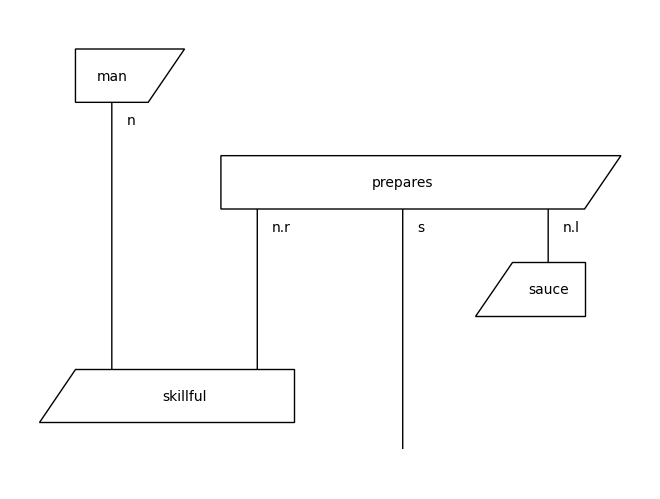

In [5]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

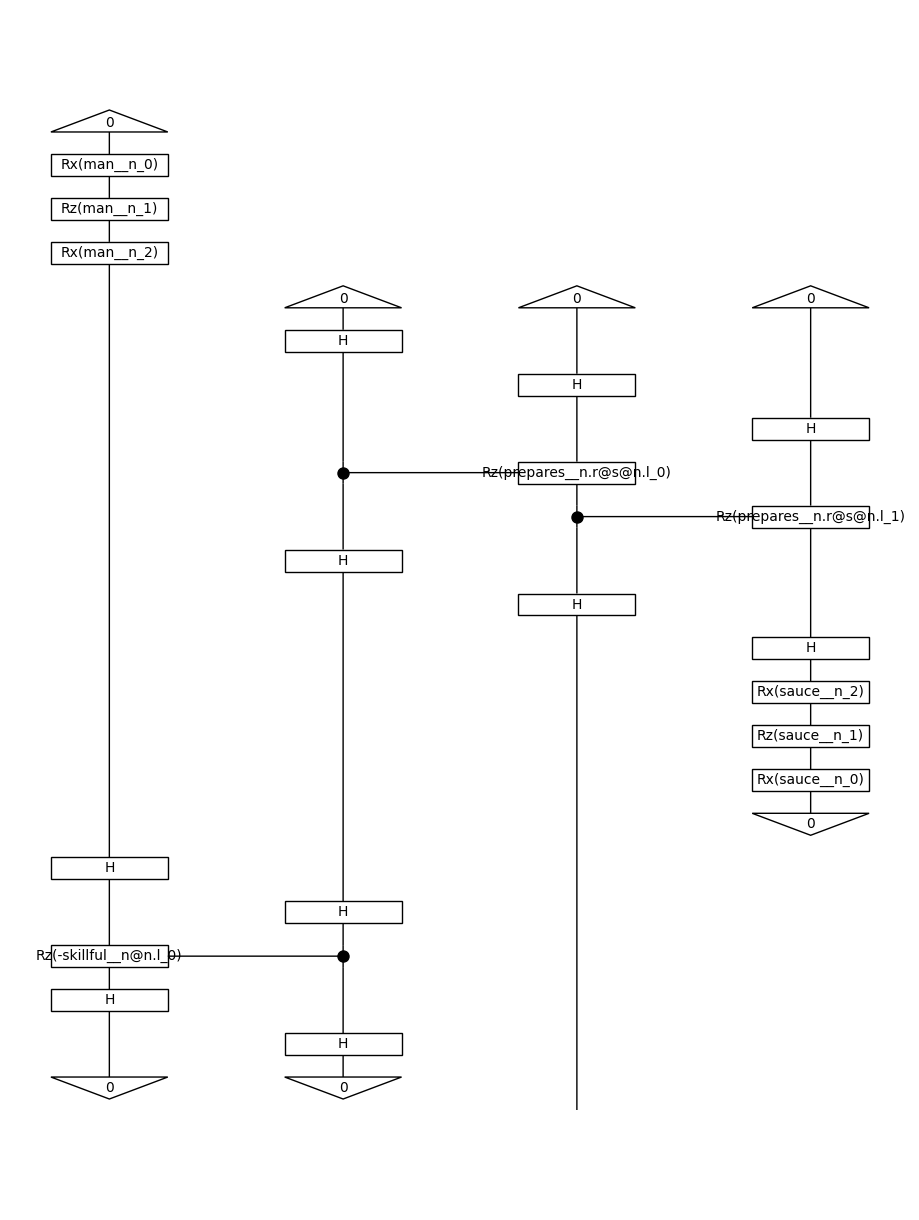

In [6]:
from lambeq import AtomicType, IQPAnsatz


ansatz_cls = IQPAnsatz
ansatz_ob_map = {AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}
ansatz_kwargs = {"n_layers": 1, "n_single_qubit_params": 3}
ansatz = ansatz_cls(
    ansatz_ob_map,
    **ansatz_kwargs,
)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

### Parameterise

In [7]:
from lambeq import NumpyModel


model = NumpyModel(use_jit=True)

### Define evaluation metric

In [8]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss(use_jax=True)

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [9]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    ansatz_cls=ansatz_cls,
    ansatz_ob_map=ansatz_ob_map,
    loss_function=bce,
    epochs=EPOCHS,
    ansatz_kwargs=ansatz_kwargs,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_diagrams,
            train_labels,
            batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_diagrams, dev_labels, shuffle=False)
test_dataset = Dataset(test_diagrams, test_labels, shuffle=False)

### Train

In [11]:
trainer.fit(train_dataset, dev_dataset, test_dataset, logging_step=12)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Epoch 1:    train/loss: 0.8925   valid/loss: 0.9476   train/acc: 0.6143   valid/acc: 0.6000
Epoch 12:   train/loss: 0.6981   valid/loss: 0.6698   train/acc: 0.6143   valid/acc: 0.5667
Epoch 24:   train/loss: 0.6343   valid/loss: 0.7871   train/acc: 0.7000   valid/acc: 0.6333
Epoch 36:   train/loss: 0.7461   valid/loss: 0.5132   train/acc: 0.5857   valid/acc: 0.6667
Epoch 48:   train/loss: 0.5399   valid/loss: 0.4889   train/acc: 0.8286   valid/acc: 0.7667
Epoch 60:   train/loss: 0.2926   valid/loss: 0.3321   train/acc: 0.9000   valid/acc: 0.8333
Epoch 72:   train/loss: 0.2401   valid/loss: 0.3198   train/acc: 0.8857   valid/acc: 0.8000
Epoch 84:   train/loss: 0.2398   valid/loss: 0.2869   train/acc: 0.9000   valid/acc: 0.8333
Epoch 96:   train/loss: 0.2059   valid/loss: 0.3156   train/acc: 0.8714   valid/acc: 0.8667
Epoch 108:  train/loss: 0.1803   valid/loss: 0.2698   train/acc: 0.9286   valid

### Show results

Test accuracy: 0.9


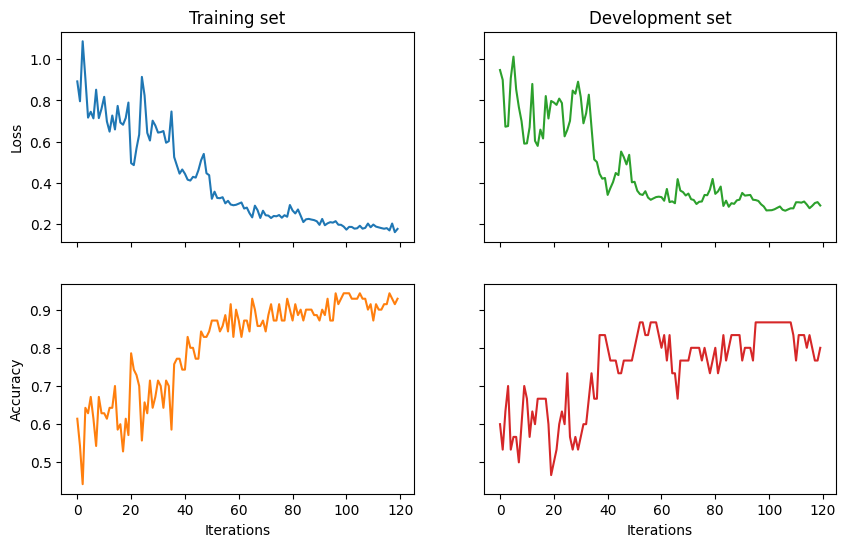

In [12]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)